# Evaluate the WRF simulations
Using pre-developed functions in *course_functions.ipynb*. ***There is no need to change this functions notebook***.

---
**Available WRF simulations:**

`Default, different land-use description:`
* **NOURBAN_SIM.nc**: urban areas replaced by its neighbouring natural land cover (W2W output)
* **LCZ_NORMS_EXTENT_SIM.nc**: Default MODIS-based urban extent replaced by the LCZ-based extent. Only one urban class with fixed parameters  (W2W output)
* **LCZ_NORMS_SIM.nc**: LCZ-Urban extent with varying urban classes and parameters  (W2W output)

`Rooftop Mitigation strategies (RMS):`
* **LCZ_CR_SIM**: as *LCZ_NORMS_SIM.nc*, but with cool roofs
* **LCZ_GR_SIM**: as *LCZ_NORMS_SIM.nc*, but with green roofs
* **LCZ_PVP_SIM**: as *LCZ_NORMS_SIM.nc*, but with photovoltaics

---
**Available observations:**

*   CWS quality-controlled timeseries of temperature 


## **General settings**

In [ ]:
# First load your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After mounting, check folders in left side-bar
# If this code does not work, you can use the "Mount Drive" button in the left side-bar

In [ ]:
# Set relevant directories
import os

# Your own baseline directory - if mounted under MyDrive, do not change.
BASE_DIR = os.path.join('/content/drive/MyDrive/BUCSS22')
#/content/drive/MyDrive/BUCSS22/Matthias_Lecturer
print('BASE_DIR: ',BASE_DIR)

# Create a link to notebooks directory
YOUR_NAME = "Matthias_Lecturer" # Name of your own folder
NOTEBOOKS_DIR = os.path.join(BASE_DIR, YOUR_NAME, 'notebooks')
print('NOTEBOOKS_DIR: ',NOTEBOOKS_DIR)

# Other relevant folders
WRF_DIR         = os.path.join(BASE_DIR, 'DATA_SHARE', 'WRF')
CWS_DIR         = os.path.join(BASE_DIR, 'DATA_SHARE', 'WRF_CWS')
OUT_DIR         = os.path.join(BASE_DIR, YOUR_NAME, 'output')
FIG_DIR         = os.path.join(BASE_DIR, YOUR_NAME, 'figures')
print('WRF_DIR: ',WRF_DIR)
print('CWS_DIR: ',CWS_DIR)
print('OUT_DIR: ',OUT_DIR)
print('FIG_DIR: ',FIG_DIR)

In [ ]:
# Put all in a dictionary to simplify usage later on
RUN_INFO = {
    'NOTEBOOKS_DIR': NOTEBOOKS_DIR,
    'WRF_DIR': WRF_DIR,
    'CWS_DIR': CWS_DIR,
    'OUT_DIR': OUT_DIR,
    'FIG_DIR': FIG_DIR,
    'DPI': 300 # Quality of the images stored to your drive
}

In [ ]:
# Prepare environment: install and import required packages
%pip install importlib-metadata==4.13.0
%pip install import_ipynb
%pip install rioxarray
%pip install scikit-learn
%pip install folium

# Load modules
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import folium
import import_ipynb

# Turn on autoreload
%reload_ext autoreload

In [ ]:
# Import functions from other notebook in Google Colab
# Cd into directory where function script is
os.chdir(RUN_INFO['NOTEBOOKS_DIR'])

# Check whether we are in the right folder
!pwd

# import the various functions made for this course
import WRF_functions as wf

# %pip install importlib-metadata==4.13.0
# import importlib
# importlib.reload(WRF_functions)
# import WRF_functions as wf

In [ ]:
# Test a function
# E.g. load LU INDEX categories, names and colors.
wf._get_info('lcz')

## **Prepare GEO_EM files with W2W**


The **WUDAPT-to-WRF tool** (W2W, [Demuzere et al., 2022](https://joss.theoj.org/papers/10.21105/joss.04432)), has been used to inject LCZ information into WRF's geo_em files.

Long story short, two procedures are followed to do this:

*   **Procedure 1**: Morphological parameters (e.g. urban fraction, building height) are assigned directly to the high-resolution LCZ map, and are afterward aggregated to the lower-resolution WRF grid
*   **Procedure 2**: radiative and thermal parameters (e.g. albedo) are assigned to the modal LCZ class that is assigned to each WRF grid cell. These parameter values are not stored in the NetCDF output but are read from [URBPARM_LCZ.TBL](https://github.com/wrf-model/WRF/blob/master/run/URBPARM_LCZ.TBL)





In [ ]:
# The information is already pre-processed for you, but you can as well run the tool yourself.

# Install it first
%pip install w2w

In [ ]:
# What version do we have? And how to run this tool?
!w2w --version

# Execute as if in terminal
!w2w --help

In [ ]:
io_dir = os.path.join(RUN_INFO['WRF_DIR'], "INPUT")
lcz_file = "global_lcz_filter_v1_ruhrarea.tif"
wrf_file = "geo_em.d03.nc"

# Run the tool - not needed here, already done as needed by the WRF simulations?
!w2w {io_dir} {lcz_file} {wrf_file}


## **Plot GEO_EM input information**

The routines below provide some insight in the lower boundary conditions provided to WRF, via the *geo_em.d0X.nc* file. 

The available scripts mainly allow you to explore the pre-scribed land use, the urban extent, and some of the assigned urban canopy parameters (eg. building height).

The routines typically require the ***geo_em file name (FN_GEO_NAME)*** as argument. For every simulation, this name is provided in the Table below (same as in the BUCSS Hands-On slides).

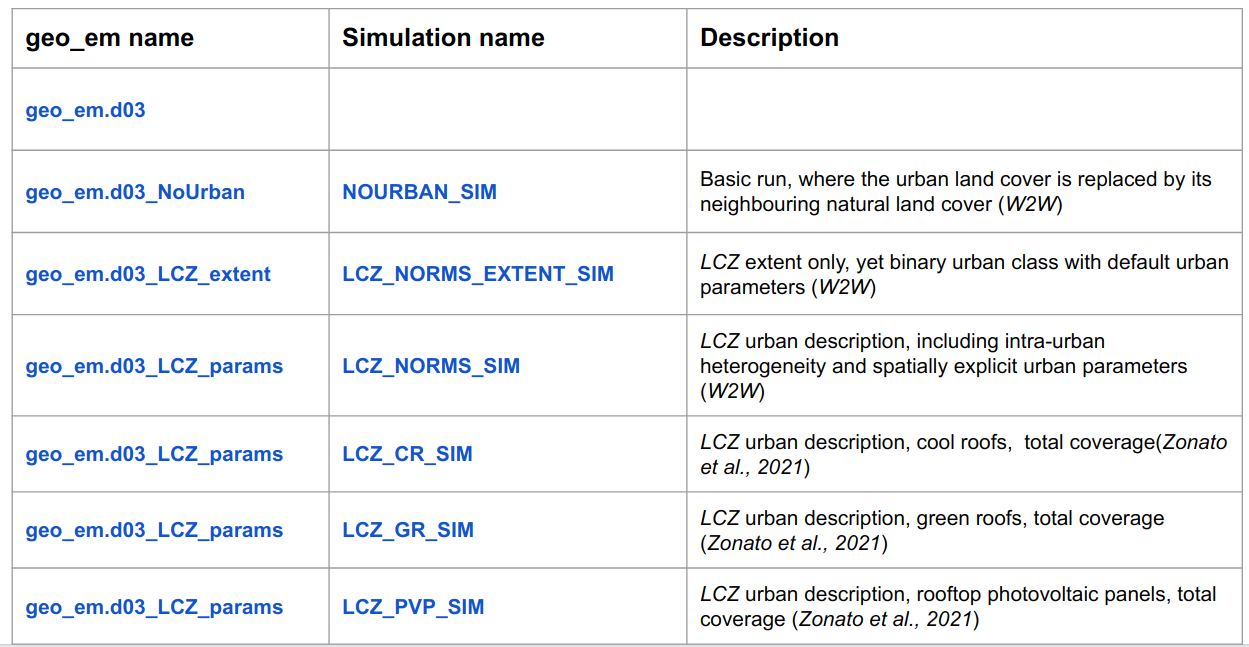

In [ ]:
# Plot Land-use (LU_INDEX) for one simulation

#FN_GEO_NAME = 'geo_em.d03'
FN_GEO_NAME = 'geo_em.d03_NoUrban'
#FN_GEO_NAME = 'geo_em.d03_LCZ_extent'
#FN_GEO_NAME = 'geo_em.d03_LCZ_params'

# Plot the land use as used in the various simulations.
wf.plot_lu_index(
    FN_GEO_NAME=FN_GEO_NAME, 
    RUN_INFO=RUN_INFO,
    )

In [ ]:
# Plot urban fraction (URB_FRAC) for 'geo_em.d03_LCZ_extent' and 'geo_em.d03_LCZ_params'
# and their difference
wf.plot_urb_frac(
    RUN_INFO=RUN_INFO,
    )

In [ ]:
# Plot some of the urban canopy parameters in the same way

# Available options:
UCP_NAME = 'BH' # Building height
#UCP_NAME = 'BHstd' # Standard deviation of building height
#UCP_NAME = "ALB_R" # Roof albedo
#UCP_NAME = "ALB_W" # Wall albedo
#UCP_NAME = "ALB_G" # Ground albedo

wf.plot_ucp(
    UCP_NAME=UCP_NAME,
    RUN_INFO=RUN_INFO,
    )

## **CWS observations**


For more information on CWS and the quality control, see:


* The "Citizen weather stations" lecture (this course)
* The "CrowdQC+ hands-on" (this course)
* Fenner et al. (2021). CrowdQC+—A Quality-Control for Crowdsourced Air-Temperature Observations Enabling World-Wide Urban Climate Applications. Front Environ Sci. 2021;9(December):1-21. doi:[10.3389/fenvs.2021.720747](doi.org/10.3389/fenvs.2021.720747)

The data used here is part of [RUB's ENLIGHT database](https://www.climate.ruhr-uni-bochum.de/research/projects/enlight/), and is:
* already quality-controlled using CrowdQC+
* extracted for the area used in the WRF simulations.


There are two files:

* *cws_heatwave_2019_bucss_metadata.csv*: containing the metadata
* *cws_heatwave_2019_bucss_data.csv*: containing the actual temperature observations and QC information

In [ ]:
# Let's have a look at the CWS data

# 1. Station metadata from .csv
fn_metadata = os.path.join(
    RUN_INFO['CWS_DIR'], 'cws_heatwave_2019_bucss_metadata.csv'
    )
metadata = pd.read_csv(fn_metadata, index_col=0)
print(metadata)

In [ ]:
# 2. Actual observations from .csv and set a multiindex
fn_data = os.path.join(
    RUN_INFO['CWS_DIR'],
    'cws_heatwave_2019_bucss_data.csv'
    )
data = pd.read_csv(
    fn_data,
    parse_dates=True,
    # set 1st level of multi index to intern_id, 2nd to date
    index_col=[0, 1],
)
print(data)

In [ ]:
# Merge the two datasources
net_all_data = data.join(metadata)
print(net_all_data.head())

In [ ]:
# First, select only CWS station in WRF domain, with QC_Level o1 = True
# This routine automates what is done in previous cells.
df = wf.get_clean_cws(
    RUN_INFO=RUN_INFO,
    QC_LEVEL="o1",
    )
print(df.head(5))

In [ ]:
# Plot the CWS stations on top of the LCZ map (100m) - STATIC.
wf.plot_LCZ_CWS_static(
    RUN_INFO=RUN_INFO,
    )

In [ ]:
# There are lots of CWS stations, hard to see where they are exactly.
# Can we plot the same information on an INTERACTIVE map?
wf.plot_LCZ_CWS_interactive(
    RUN_INFO=RUN_INFO,
    )

In [ ]:
# Have a more detailed look at the temperatue information observed by the CWS network.
# Plot  CWS temperatures stratified per LCZ and day | day-time | night-time:
NET_VAR = 'ta_int'
wf.plot_cws_grouped(
    NET_VAR=NET_VAR,
    RUN_INFO=RUN_INFO,
    )

In [ ]:
# Plot average diurnal cycle, per LCZ class.
# - One subplot for the built LCZs
# - One subplot for the natural land cover types
# - One subplot for difference between two LCZ classes (REF1 and REF2)

NET_VAR = 'ta_int'
REF1=2
REF2=14
wf.plot_cws_diurnal_cycle(
    NET_VAR=NET_VAR, 
    REF1=REF1, 
    REF2=REF2, 
    RUN_INFO=RUN_INFO,
    )

## **WRF Evaluation**

Most of the routines below require the ***simulation name (SIM_NAME)*** as argument. This sections focusses on the simulations listed below, to 1) assess the impact of different land use definitions, and 2) evaluate their skill using the available CWS observations:

`Different (urban) land use definitions:`
* **NOURBAN_SIM**: urban areas replaced by its neighbouring natural land cover (W2W output)
* **LCZ_NORMS_EXTENT_SIM**: Default MODIS-based urban extent replaced by the LCZ-based extent. Only one urban class with fixed parameters  (W2W output)
* **LCZ_NORMS_SIM**: LCZ-Urban extent with varying urban classes and parameters  (W2W output)

In [ ]:
# Plot T2 timeseries of a variable at an coordinate of choice (within WRF domain)
# If CWS observations are available within the selected grid cell,
# they will be added to the plot.

# Note that the 3 different land use simulations are plotted at once.

# HINT: You could use the interactive map to find a coordinate of interest.
stnlat = 50.9333879561492
stnlon = 6.99

wf.eval_T2_1px_wrf_cws_time(
    stnlat=stnlat, 
    stnlon=stnlon, 
    RUN_INFO=RUN_INFO,
  )

In [ ]:
# Of course, WRF also produces other variables that can be looked at.
# Unfortunately we have no observations to evaluate them, but
# we can compare the timeseries between the different simulations.

# Variables that are plotted:
# - SWDOWN: DOWNWARD SHORT WAVE FLUX AT GROUND SURFACE
# - GLW: DOWNWARD LONG WAVE FLUX AT GROUND SURFACE
# - HFX: UPWARD HEAT FLUX AT THE SURFACE
# - LH: LATENT HEAT FLUX AT THE SURFACE
# - TSK: SURFACE SKIN TEMPERATURE
# - PBLH: PBL Height

stnlat = 51.2069
stnlon = 6.7797

wf.eval_vars_1px_wrf_cws_time(
    stnlat=stnlat, 
    stnlon=stnlon, 
    RUN_INFO=RUN_INFO,
  )

In [ ]:
# Get error metrics table: 
# for every pixel in WRF domain that has CWS stations,  
# save the RMSE, R2 and MBE accuracy metrics as a table in output/ folder.

# This table also contains some metadata (eg. model elevation, LU_INDEX, URB_FRAC)
# that can be used to stratify the results and get a better understanding.

# NOTE: processing this table for one simulation takes ~10 min:
# ==> Tables have been pre-processed, and are available in output/

#SIM_NAME = 'NOURBAN_SIM' # URB_FRAC = 0
#SIM_NAME = 'LCZ_NORMS_EXTENT_SIM' # URB_FRAC = 0.9
#SIM_NAME = 'LCZ_NORMS_SIM'

# wf.get_error_table_wrf_vs_cws(
#     SIM_NAME=SIM_NAME,
#     RUN_INFO=RUN_INFO, 
#   )
  
# for SIM_NAME in ['NOURBAN_SIM', 'LCZ_NORMS_EXTENT_SIM', 'LCZ_NORMS_SIM']:
#   wf.get_error_table_wrf_vs_cws(
#       SIM_NAME=SIM_NAME,
#       RUN_INFO=RUN_INFO, 
#     )

In [ ]:
# Read the error matrix and plot spatially
# Size of the error dot scaled according to # CWS stations.
# Plot includes 'URB_FRC2D' and 'HGT_M' from WRF geo_em file.

# For a similar analysis, see eg. preprint of Brousse et al. (2022), their Fig.3:
# https://doi.org/10.1002/essoar.10512277.1

# Select error metric you want to plot
#ERROR_VAR = 'RMSE'
ERROR_VAR = 'R2'
#ERROR_VAR = 'MBE'

# Select simulation you want to plot error metrics for
#SIM_NAME = 'NOURBAN_SIM'
SIM_NAME = 'LCZ_NORMS_EXTENT_SIM'
#SIM_NAME = 'LCZ_NORMS_SIM'

wf.plot_error_wrf_cws_spatially(
    ERROR_VAR=ERROR_VAR, 
    SIM_NAME=SIM_NAME, 
    RUN_INFO=RUN_INFO,
  )

In [ ]:
# Plot error metric stratified per LCZ | HGT | URB_FRC2D
# As Boxplots, with dot = mean, line = median, box = [25, 75], whiskers = [5, 95]

# Select error metric you want to plot
#ERROR_VAR = 'RMSE'
#ERROR_VAR = 'R2'
ERROR_VAR = 'MBE'

# All simulations are plotted at once.
wf.plot_error_wrf_cws_bxp_lu_urb_hgt(
    ERROR_VAR=ERROR_VAR, 
    RUN_INFO=RUN_INFO,
  )

## **WRF Mitigation strategies**

Most of the routines below require the ***simulation name (SIM_NAME)*** as argument. 

This section works with the following simulations:

`Default, using LCZ information:`
* **LCZ_NORMS_SIM**: LCZ-Urban extent with varying urban classes and parameters  (W2W output)

`Rooftop Mitigation strategies (RMS):`
* **LCZ_CR_SIM**: as *LCZ_NORMS_SIM.nc*, but with cool roofs
* **LCZ_GR_SIM**: as *LCZ_NORMS_SIM.nc*, but with green roofs
* **LCZ_PVP_SIM**: as *LCZ_NORMS_SIM.nc*, but with photovoltaics

<br>
For more information on these strategies, see 

*Zonato, A., Martilli, A., Gutierrez, E., Chen, F., He, C., Barlage, M., et al. (2021). Exploring the effects of rooftop mitigation strategies on urban temperatures and energy consumption. Journal of Geophysical Research: Atmospheres, 126, e2021JD035002. https://doi.org/10.1029/2021JD035002*

In [ ]:
# Let' have a look at variable timeseries at an coordinate of choice (within WRF domain).
# Note that the 4 different simulations are plotted at once.

# HINT: You could use the interactive map to find a coordinate of interest.
stnlat = 51.2069
stnlon = 6.7797

wf.plot_vars_1px_wrf_rms_time(
    stnlat=stnlat, 
    stnlon=stnlon,
    RUN_INFO=RUN_INFO,
    )


In [ ]:
# We can plot the same information, yet this time as a difference: RMS (3) - NORM

stnlat = 51.2069
stnlon = 6.7797

wf.plot_vars_1px_wrf_rms_time_diff(
    stnlat=stnlat, 
    stnlon=stnlon,
    RUN_INFO=RUN_INFO,
    )

In [ ]:
# Make a spatial map of a variable, for two simulations, including their difference
# Results are shown as the mean for day (24h), day-time (between SR and SS), and night-time

SIM_NAME1 = 'LCZ_NORMS_SIM'
SIM_NAME2 = 'LCZ_GR_SIM'

# You can try out the same variables as above.
# Yet two other variables are available for the RMS simulations:
# - CM_AC_URB3D: CONSUMPTION OF THE AIR COND.
# - EP_PV_URB3D: ELEC. PRODUCTION OF ROOFTOP PV PANELS - only for PVP of course.

VAR = 'T2'
#VAR = 'HFX'
#VAR = 'CM_AC_URB3D'

wf.map_var_rms(
    VAR=VAR, 
    SIM_NAME1=SIM_NAME1, 
    SIM_NAME2=SIM_NAME2, 
    RUN_INFO=RUN_INFO,
    ) 

In [ ]:
# According to Zonato et al. (2021), the mitigation effect of RMS 
# is dependent 1) on the urban configuration, and 2) the time of the day
# Let us therefor plot the average diurnal cycle of variable, 
# for all simulations, stratified per LCZ class

# As this stratification takes a (little) bit of time,
# we first pre-process this information into tables (seperate .csv for the mean and std per LU_INDEX), 
# stored in the output/ folder.


# Set your variable of interest
VAR = 'T2'
#VAR = 'CM_AC_URB3D'
#VAR = 'LH'
#VAR = 'HFX'

SIM_NAMES = [
  'LCZ_NORMS_SIM', 
  'LCZ_CR_SIM', 
  'LCZ_GR_SIM',
  'LCZ_PVP_SIM',
]

for SIM_NAME in SIM_NAMES:
  wf._store_diurnal_lu_T_for_RMS_to_table(
      VAR=VAR, 
      SIM_NAME=SIM_NAME, 
      RUN_INFO=RUN_INFO,
  )

In [ ]:
# Plot this information, as diurnal cycles per SIM_NAME, stratified per LCZ.
# Line colors depict the land use class
# Note that all natural land use classes are grouped as 1 class.

# Set variable to plot
VAR = 'T2'
#VAR = 'CM_AC_URB3D'
#VAR = 'LH'
#VAR = 'HFX'

wf.plot_WRF_RMS_var_diurnal_cycle_lcz(
    VAR=VAR, 
    RUN_INFO=RUN_INFO,
    METRIC='mean', #also std is possible
)

In [ ]:
# Plot the same, but this time the difference between RMS and NORM
# Again stratified per LCZ

# Set variable to plot
VAR = 'T2'
#VAR = 'CM_AC_URB3D'
#VAR = 'LH'
#VAR = 'HFX'

wf.plot_WRF_RMS_var_diurnal_cycle_lcz_diff(
    VAR=VAR, 
    RUN_INFO=RUN_INFO,
    METRIC='mean', #also std is possible
)
